# Swarming

In nature, swarms of animals are capable of amazing feats. For example schools of fish are able to confuse and evade a predator, swarms of ants are able to find the shortest path towards a food source, and swarms of honeybees can make informed choices on new nest locations. It is inspiring to see how animals with limited cognitive abilities are able to transcend their individual capabilities by being part of a swarm. 

The field of _swarm robotics_ has two main goals:
<OL>
    <LI style="margin-bottom: 10px;"><B>Understand biological systems:</B> The robots (or simulated agents) in the swarm serve as a model for animals. This allows to test hypotheses on the animals and their governing behavioral rules.</LI>
    <LI style="margin-bottom: 10px;"><B>Design robotic swarms:</B> This goal entails setting up a system consisting of many robots that are individually limited, but that together are able to perform complex tasks. Robotic swarms promise to form a _flexible_, _robust_, and _scalable_ solution.</LI>
</OL>

A central challenge in swarming research is that it concerns a _complex_ system in the true sense of the word:

_"**Complexity** characterises the behaviour of a system or model whose components interact in multiple ways and follow local rules, meaning there is no reasonable higher instruction to define the various possible interactions" -_ <A HREF="https://en.wikipedia.org/wiki/Complexity" TARGET="_blank">Wikipedia</A>

In order to get a better understanding of the issues involved in swarm robotics, this notebook will have you implement some basic behaviors for a swarm of simulated drones.         

## Simple swarm environment and agents

We will employ a simple, rectangular environment with simple agents that have a position, heading and velocity. The agent can determine velocity and heading rate commands, which are executed with a certain delay (low-pass filtered). All classes, `Environment`, `Agent`, etc. are defined in the file `swarming.py`.

Let us first make and run 10 "random" agents. These agents draw their velocity $v$ and heading rate $r$ from a uniform random distribution, and are hence blissfully unaware of each other. Specifically, $v \in [0, 1]$ and $r \in [-0.1 \pi, 0.1 \pi]$.

<FONT COLOR="red"><B>Exercise 1</B></FONT>
<OL>
    <LI>**Before running the code and reading on:** What do you expect the random agents to do? Do you expect a global pattern to arise from their behavior?</LI>
    <LI>Run the code. Can you observe a global pattern arising from the local behavior? If yes, why do you think this arises? Can you break the pattern by changing the random distributions? If no, why do you think there is no pattern?</LI>
</OL>

In [ ]:
%matplotlib inline
from swarming import *

# extend the agent class to take random actions:
class RandomAgent(Agent):
    
    def set_command(self):
        
        # draw velocity and rate from a uniform distribution:
        self.command_v = np.random.rand(1)
        self.command_rate = 0.1 * np.pi * (np.random.rand(1) * 2 - 1)

# create environment and agents:
env = Environment(100, 100)
for i in range(10):
    a = RandomAgent(env)
    env.add_agent(a)


# run the sim for a number of time steps and draw it:
dt = 0.1
n_time_steps = 10000

for t in range(n_time_steps):
    
    env.update_agents(dt)
    
    if(np.mod(t, 100) == 0):
        env.draw()

## Flocking

We will now make a next step, and create a swarm that attempts to behave like a flock of birds. It is often said that the complex behavior of such flocks can be adequately modeled by means of a few simple rules. To put this to the test, we will implement the following famous flocking rules:

<OL>
    <LI>Separation: Avoid collisions with other swarm members</LI>
    <LI>Cohesion: Don't get separated from the flock</LI>
    <LI>Alignment: Align your velocity with that of your neighbors</LI>
</OL>

In order to implement these behaviors, we will make use of the function in the Agent class called `sense_nearest_neighbors`. It has two parameters, `k` which is the maximum number of neighbors considered, and `max_range` outside of which other swarm members are not observed. The observation model is omnidirectional and allows an agent to determine the velocity of the other agents (see the alignment rule, which needs this). The outputs of this function consists of: `neighbors`, the indices of the agents as ranked in the environment, `delta_pos` which contains per neighbor the relative position in body coordinates, and `delta_v` which gives the relative velocity in body coordinates.

In order to understand the relative coordinates, please have a look at the coordinate frames below, where $X$ and $Y$ indicate the inertial frame, and $x_B$ and $y_B$ the body frame. Also please note that the agents have a maximal range, beyond which they will not detect other agents (dashed circles). Hence, if there were only these two agents, they would not perceive each other and receive empty lists from the `sense_nearest_neighbors` function.

<IMG SRC="coordinate_systems.png" WIDTH="500"></IMG>


<FONT COLOR="red"><B>Exercise 2</B></FONT>

In this exercise, we are going to implement a simple flocking model.

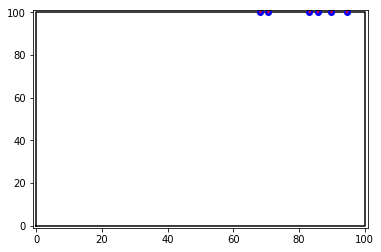

KeyboardInterrupt: 

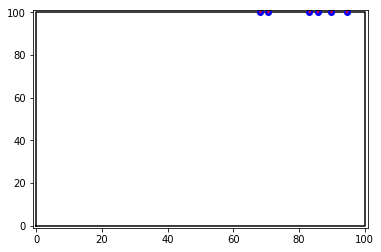

In [2]:
%matplotlib inline
from swarming import *

# extend the agent class to take random actions:
class FlockingAgent(Agent):
    
    def set_command(self):
        
        # sense the neighbors:
        [neighbors, delta_pos, delta_v] = self.sense_nearest_neighbors(k=10, max_range = 1000.0)
        n_neighbors = len(neighbors)
        
        if(n_neighbors == 0):
            # no neighbors, keep going in the same direction:
            self.command_rate = 0.0
            return
        
        # parameters of the method:
        avoidance_radius = 10.0
        w_separation = 0.0
        w_cohesion = 0.0
        w_alignment = 50.0
        command_velocity = 0.25
        rate_gain = 0.10
        
        # initializing variables:
        avoidance_vector = np.zeros([2,1])
        avoidance = False
        flock_centroid = np.zeros([2,1])
        delta_v_align = np.zeros([2,1])
        
        for n in range(n_neighbors):
            d_pos = delta_pos[n]
            distance = np.sqrt(d_pos[0]*d_pos[0] + d_pos[1]*d_pos[1])
            
            # separation:
            if distance < avoidance_radius:
                avoidance = True
                avoidance_vector -= d_pos / np.linalg.norm(d_pos)
        
            # cohesion:
            flock_centroid += d_pos / np.linalg.norm(d_pos)
            
            # alignment:
            d_vel = delta_v[n]
            delta_v_align += d_vel
        
        if(avoidance):
            # normalize the avoidance vector:
            avoidance_vector /= np.linalg.norm(avoidance_vector)
        else:
            avoidance_vector = np.zeros([2,1])
        
        # cohesion vector:
        flock_centroid /= (n_neighbors + 1) # +1 because the agent itself counts for the centroid
        flock_centroid /= np.linalg.norm(flock_centroid)
        
        # alignment:
        v_body = np.zeros([2,1])
        v_body[0] = self.v
        v_body[1] = 0
        v_alignment = v_body + delta_v_align / n_neighbors
        
        desired_v = w_separation * avoidance_vector + w_cohesion * flock_centroid + w_alignment * v_alignment 
        norm_dv = np.linalg.norm(desired_v)
        if norm_dv > 0.0001:
            desired_v /= norm_dv
        desired_v *= command_velocity
        
        # set the new commanded velocity and rate:
        self.command_v = command_velocity
        self.command_rate = -rate_gain * desired_v[1][0]
        

# create environment and agents:
env = Environment(100, 100)
for i in range(20):
    a = FlockingAgent(env)
    env.add_agent(a)

# run the sim for a number of time steps and draw it:
dt = 0.1
n_time_steps = 10000

for t in range(n_time_steps):
    
    env.update_agents(dt)
   
    if(np.mod(t, 100) == 0):
        env.draw()       

## Answers

<FONT COLOR="red"><B>Exercise 1</B></FONT>
<OL>
    <LI>There is no good answer for what to expect. The most common expectation is probably that no pattern will arise, as the agents just act randomly.</LI>
    <LI>The agents tend to accumulate at the borders of the environment. The state update equations in the agent do not allow it to cross those borders. This happens because the heading changes much less than the velocity. If you change `self.command_rate = 0.1 * np.pi * (np.random.rand(1) * 2 - 1)` to `self.command_rate = 1.0 * np.pi * (np.random.rand(1) * 2 - 1)` agents will also leave the border again. The interaction that leads to this behavior is the combination of the environment and the random agent - although arguably this interaction is not so complex.</LI>
</OL>

